**General tactics**:

In this Notebook, we address two questions
1. What is the precise relationship between level of mobility reduction and national level of cases?
2. At what geographical level is isolation most important?

We answer the first question in various scenarios at arrondissement level:
- Choose between 'keeping the virus out' or 'keeping the virus in' (two scenarios).
	- Keeping it out: initial condition corresponds to data (Limburg and Mons)
	- Keeping it in: initial condition coresponds to isolated NIS
- Choose between which region to isolate (two extremes)
	- Isolate Brussels (most-connected)
	- Isolate least-connected (in terms of staytime)
    - Time and computation allowing: simulate for all regions
- Simulate for a logarithmic range of p-values for that particular region. p=0 is total isolation (trivial case), p=1 is regular mobility
- Simulate two types of mobility
    - Use baseline mobility for all days (no time-dependence on days), and reduce mobility only in one particular region by reducing its p-value
    - Update mobility on a daily basis (observed reduced mobility), and add _additional_ local mobility reduction by decreasing p-value
- Output
    - Total number of deaths at fixed final date of simulation, scatterplot, showing linear/sublinear/superlinear relationship
    - Evolution of deaths over entire simulation period for various p-values (spectrum of curves)
    - Which deaths? Deaths in isolated region, and deaths in all the other regions.
    - Absolute or relative? Both is probably interesting

We answer the second question by going through the same process as before, but at _provincial_ level and at _municipality_ level. This is arguably not entirely comparable, but it gives an impression.

Considering this is an artificial simulation, it does not really matter what time frame we are talking about, but let us simply focus on the first wave and its policies. On the other hand, this is also something that may be played with:
- Show simulation for realistic policy changes
- Show simulation for no policy changes whatsoever (downside: this may saturate to a catastrophe rather fast, such that clear distinctions between various p-values can no longer be made)

**Assumptions**
1. People that do not travel and therefore stay within their local region, are modelled to behave in the _same way_ as other people, whilst in reality these people will have fewer contacts (working at home)

**Background**

Changing the $p$ parameter (dimension $G$) alters the effective mobility matrix $P$ (dimension $G \times G$) as follows:

$$\left(P^{gh}\right)' = P^{gh} p^g p^h + \delta^{gh}\sum_{f=1}^G P^{gf}(1-p^f p^h)$$

Which in the source code translates to
```
place_eff = np.outer(p, p)*place + np.identity(G)*np.matmul(place, (1-np.outer(p,p)))
```

## A little demonstration of the effect of changing p

In [1]:
# A little demonstration
import numpy as np

# Define baseline mobility
G = 3
place = np.array([[0.90, 0.05, 0.05],
                  [0.20, 0.70, 0.10],
                  [0.30, 0.20, 0.50]])
# Define mobility parameter
p = np.ones(G)
# Restrict mobility to/from the second location by 50 percent
p[1] = 0.5

# Define effective mobility
place_eff = np.outer(p, p)*place + np.identity(G)*np.matmul(place, (1-np.outer(p,p)))

# Note how all diagonal elements have increased,
# Note how all nondiagonal elements in the second row and the second column have decreased
# Note how the mobity between the first and the third region is unaffected.
place_eff

array([[0.925, 0.025, 0.05 ],
       [0.1  , 0.85 , 0.05 ],
       [0.3  , 0.1  , 0.6  ]])

In [2]:
place_eff + place

array([[1.825, 0.075, 0.1  ],
       [0.3  , 1.55 , 0.15 ],
       [0.6  , 0.3  , 1.1  ]])

# Load common model properties

Common: lockdown properties, social contact rates, most model parameters, start date, end date, aggregation level, p-range

In [114]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import lockdown_func, policies_wave1_4prev
from covid19model.models.time_dependant_parameter_fncs import load_all_mobility_data, make_mobility_update_func

# Moving average for visualisation
from covid19model.visualization.utils import moving_avg
from covid19model.models.utils import read_pops, read_coordinates_nis, initial_state


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Resolution for saving images
figsize=(16/1.5, 9/1.5)
dpi=400

# Spatial stratification
agg = 'arr'
G = 43

# Load p-range

# linear
n_steps = 101 # Number of steps to get to p=1
p_values = np.round(np.linspace(0, 1, n_steps),3) # use np.round to avoid numerical floating point errors
 
# logaritmic
# p_values_lowest = 0.0001
# exponent = -np.log10(p_values_lowest)
# p_values = p_values_lowest * np.logspace(0, exponent, n_steps)
# plt.plot(p_values)
# plt.yscale('log')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Load common model parameters

# Contact matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=agg)
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)

# Add the social effect of the first lockdown
params.update({'Nc_all' : Nc_all,
               'df_google' : df_google,
               'l': 13.25,
               'tau': .1,
               'prev_schools': 1, # hard-coded
               'prev_work': 0.16, # 0.5 # taken from Tijs's analysis
               'prev_rest': 0.28, # 0.5 # taken from Tijs's analysis
               'prev_home' : 0.7})# 0.5 # taken from Tijs's analysis

# This will need to be adjusted soon if the new vaccination strategy for spatial is implemented.
# These values do not matter at present
params.update({'leakiness' : np.zeros(9),
               'e' : np.ones(9),
               'N_vacc' : np.zeros(9),
               'v' : np.ones(9), # depending on age stratification
               'K' : 1})

# Remove redundant parameters. Again, this should have a nicer form after the update
params.pop('K_inf')
params.pop('K_hosp')

start_date = pd.to_datetime('2020-01-15')
end_date = pd.to_datetime('2020-05-15')

# Load all available Proximus mobility data
all_mobility_data, average_mobility_data = load_all_mobility_data(agg)


# Define average prepandemic mobility
first_prepandemic_date = pd.to_datetime('20200210', format="%Y%m%d") # Monday
last_prepandemic_date = pd.to_datetime('20200315', format="%Y%m%d") # Sunday

# all_mobility_data.loc[first_prepandemic_date, 'place']

day_count = (last_prepandemic_date - first_prepandemic_date).days + 1
available_day_count = 0
available_data = np.zeros((G, G)) # for arrondissements
for date in (first_prepandemic_date + pd.Timedelta(n, unit='days') for n in range(day_count)):
    try:
        available_data_today = all_mobility_data.loc[date, 'place']
        available_data += available_data_today
        available_day_count += 1
    except:
        continue
        
average_prepandemic_mobility = available_data / available_day_count
# Make sure this is normalised (there are some super small rounding errors that are probably not relevant, but OK)

rounding_error = np.ones(G) - average_prepandemic_mobility.sum(axis=1)
average_prepandemic_mobility[:,0] += rounding_error

## Define plot creator

In [136]:
def show_isolation_effect(out_dict, NIS_isolated, p_values, dtype='result', compartment='D', NIS=None, figsize=(15,5), color='maroon'):
    '''
    Function to create plot of the simulation for various mobility reductions.
    
    Input
    -----
    out_dict : dict
        Dictionary with p values as keys and simulation outputs (xarray) as values
    NIS_isolated : int
        The NIS code of the region whose mobility has been altered
    pvalues : np.array
        Array with p values ranging from 0 to 1.
    dtype : str
        Choose between 'timeseries' and 'result' (default)
    compartemnt : str
        Choose the department to show the plot of. Choose between 'D' (default) or 'H_in'. In case dtype='result' and 
        compartment='H_in', the output is the cumulative sum over the simulation time.
    NIS : int
        Choose NIS code of the region to be depicted. If None (default) the output represents the national result.
    figsize : tuple
        Choose size of the output plot. Default is (15,5).
        
    Returns
    -------
    fig : matplotlib pyplot fig object
    ax : matplotlib pyplot ax object
    '''
    if dtype not in ['timeseries', 'result']:
        raise Exception(f"dtype={dtype} is not a legitimate choice. Choose between 'timeseries' or 'result'.")
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel(compartment, fontsize=20)
    ax.set_xlabel(None)
    
    alpha=0.2
    linewidth=2
    
    if dtype=='timeseries':
        if NIS:
            for p_value in p_values:
                local_comp_timeseries = out_dict[p_value].sel(place=NIS).sum(dim='Nc')[compartment]
                local_comp_timeseries.plot(color=color, linewidth=linewidth, alpha=alpha, ax=ax)
                ax.set_title(f"Timeseries in {NIS} by controlling mobility to/from {NIS}")
            return fig, ax
        else:
            for p_value in p_values:
                total_comp_timeseries = out_dict[p_value].sum(dim='place').sum(dim='Nc')[compartment]
                total_comp_timeseries.plot(color=color, linewidth=linewidth, alpha=alpha, ax=ax)
                ax.set_title(f"Timeseries at national level by controlling mobility to/from {NIS_isolated}")
            return fig, ax
            
    elif dtype=='result':
        ax.set_xlabel(r'$p$', fontsize=20)
        comp_results_array = np.zeros(len(p_values))
        if NIS:
            if compartment=='D':
                for idx, p_value in enumerate(p_values):
                    local_comp_result = out_dict[p_value].sel(place=NIS).sum(dim='Nc')[compartment][-1]
                    comp_results_array[idx] = local_comp_result
                ax.plot(p_values, comp_results_array, color=color, linewidth=2)
                ax.set_title(f"Effect of imposed mobility to/from {NIS_isolated} on death count in {NIS}")
                return fig, ax
            elif compartment=='H_in':
                for idx, p_value in enumerate(p_values):
                    local_comp_result = out_dict[p_value].sel(place=NIS).sum(dim='Nc')[compartment].sum()
                    comp_results_array[idx] = local_comp_result
                ax.plot(p_values, comp_results_array, color=color, linewidth=2)
                ax.set_title(f"Effect of imposed mobility to/from {NIS_isolated} on total hospitalisations in {NIS}")
                return fig, ax
        else:
            if compartment=='D':
                for idx, p_value in enumerate(p_values):
                    local_comp_result = out_dict[p_value].sum(dim='place').sum(dim='Nc')[compartment][-1]
                    comp_results_array[idx] = local_comp_result
                ax.plot(p_values, comp_results_array, color=color, linewidth=2)
                ax.set_title(f"Effect of imposed mobility to/from {NIS_isolated} on death count at national level")
                return fig, ax
            elif compartment=='H_in':
                for idx, p_value in enumerate(p_values):
                    local_comp_result = out_dict[p_value].sum(dim='place').sum(dim='Nc')[compartment].sum()
                    comp_results_array[idx] = local_comp_result
                ax.plot(p_values, comp_results_array, color=color, linewidth=2)
                ax.set_title(f"Effect of imposed mobility to/from {NIS_isolated} on total hospitalisations at national level")
                return fig, ax

# Model: keeping it in
Drop 3 40-year-olds in Brussels/Arlon (see below), and look at effect.

## With average prepandemic mobility as baseline

In [149]:
params.update({'place' : average_prepandemic_mobility})
savename_prefix=f"effect-of-isolation_{agg}_keeping-it-in_fixed-baseline-mobility"

# Save figures
save=True

### Partial isolation of Brussels

In [44]:
# Set this to True if you want to run. Takes approximately 5 minutes
rerun=False

# Identify arrondissement Brussels and find corresponding index in the NIS list
NIS = 21000
NIS_list = read_coordinates_nis(spatial=agg)
p_index = np.where(NIS_list==NIS)[0][0]

# Initialise mobility parameter array (no mobility policy)
p = np.ones(len(NIS_list))

# Define simulation result dictionary
results_dict = dict.fromkeys(p_values)

# Initial states
initE = initial_state(dist=NIS, agg=agg, age=40, number=3) # 3 40-somethings dropped in Brussels
initial_states = {'S': initN, 'E': initE}

if rerun==True:
    for p_value in p_values:
        # Update mobility parameter array with new p-value
        p[p_index] = p_value
        params.update({'p' : p})
        # Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
        # Note: no time-dependent mobility
        model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters \
                                                   = {'Nc' : policies_wave1_4prev}, spatial=agg)
        out = model_wave1.sim(end_date, start_date=start_date)
        results_dict[p_value] = out
        print(f"Finished working on p={p_value}   ", end='\r')

**RESULTS**

*Result for Brussels*

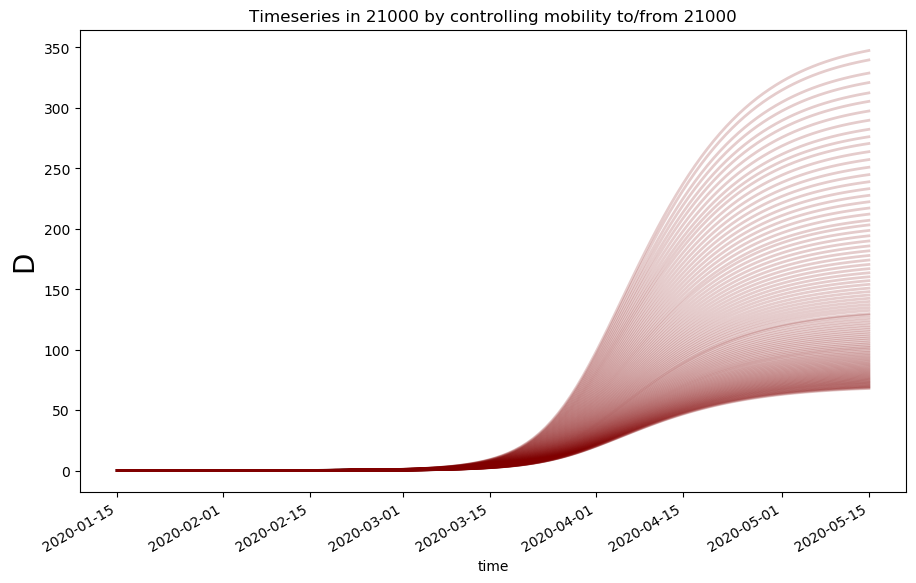

In [143]:
NIS_isolated=21000
NIS=21000
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

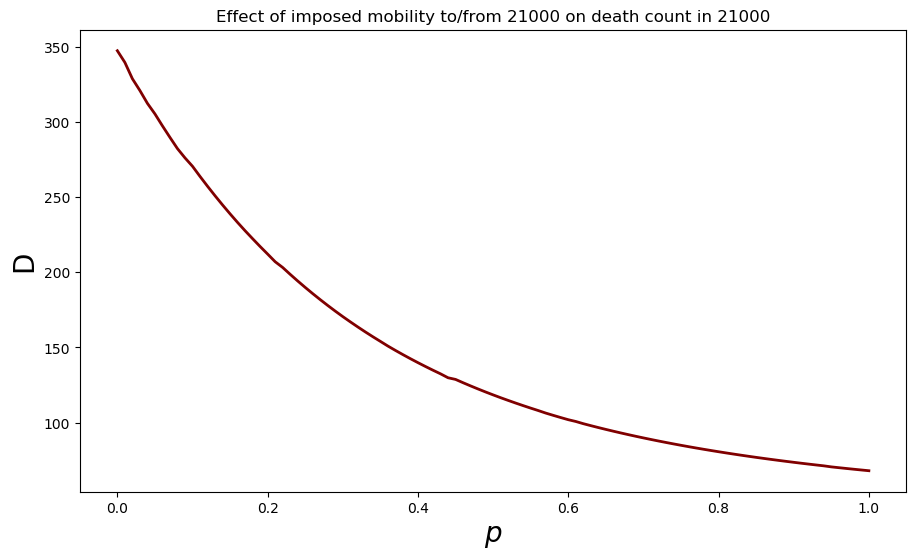

In [144]:
NIS=21000
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

*Result for all of Belgium*

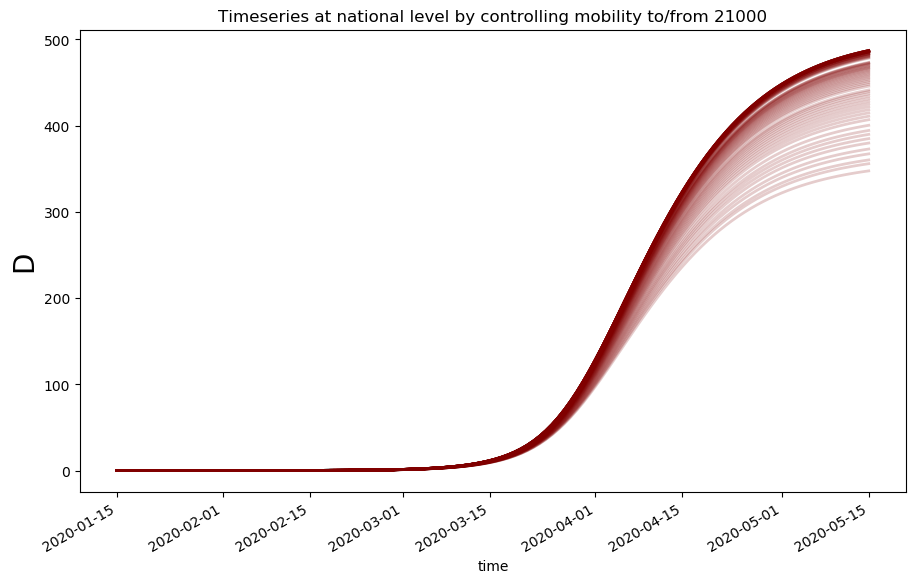

In [147]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

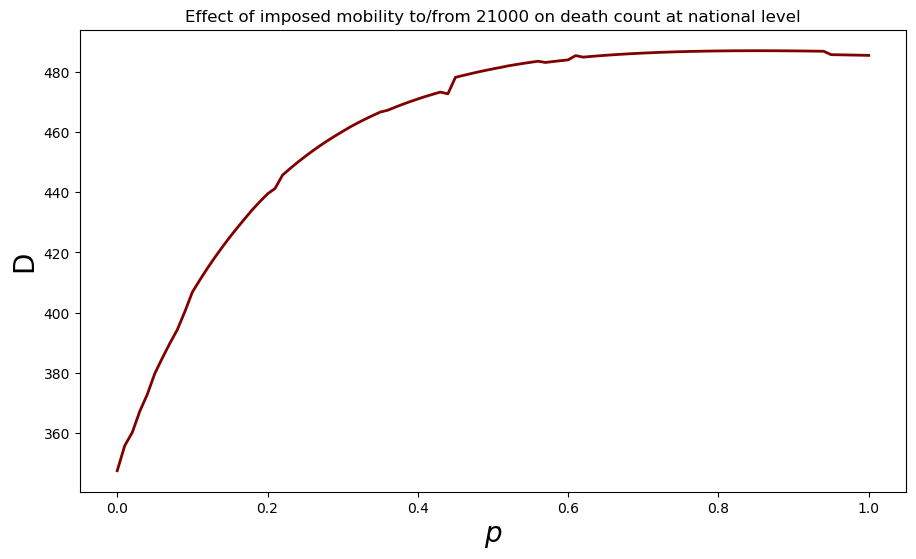

In [148]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

### Partial isolation of Arlon

In [150]:
# Set this to True if you want to run. Takes approximately 5 minutes
rerun=False
color='olive'

# Identify arrondissement Brussels and find corresponding index in the NIS list
NIS = 81000
NIS_list = read_coordinates_nis(spatial=agg)
p_index = np.where(NIS_list==NIS)[0][0]

# Initialise mobility parameter array (no mobility policy)
p = np.ones(len(NIS_list))

# Initial states
initE = initial_state(dist=NIS, agg=agg, age=40, number=3) # 3 40-somethings dropped in Arlon
initial_states = {'S': initN, 'E': initE}

if rerun==True:
    # Define simulation result dictionary
    results_dict = dict.fromkeys(p_values)
    for p_value in p_values:
        # Update mobility parameter array with new p-value
        p[p_index] = p_value
        params.update({'p' : p})
        # Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
        # Note: no time-dependent mobility
        model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters \
                                                   = {'Nc' : policies_wave1_4prev}, spatial=agg)
        out = model_wave1.sim(end_date, start_date=start_date)
        results_dict[p_value] = out
        print(f"Finished working on p={p_value}   ", end='\r')

**RESULTS**

*Results for Arlon*

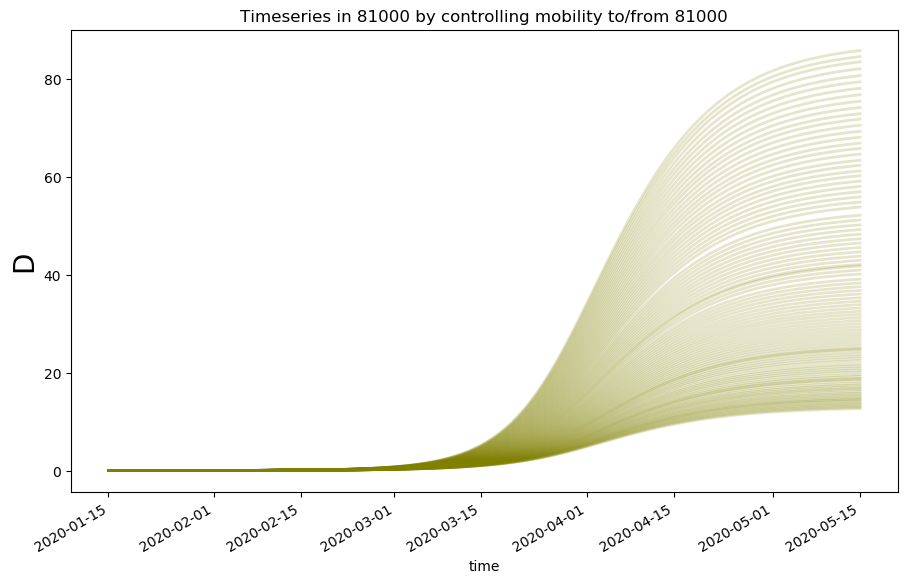

In [155]:
NIS_isolated=81000
NIS=81000
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, \
                                NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

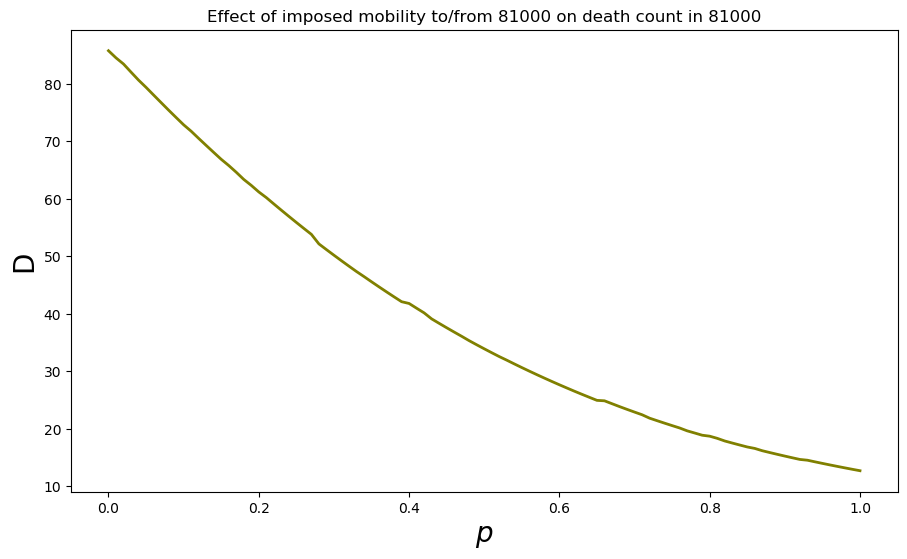

In [156]:
NIS=81000
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, \
                                NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

*Results for all of Belgium*

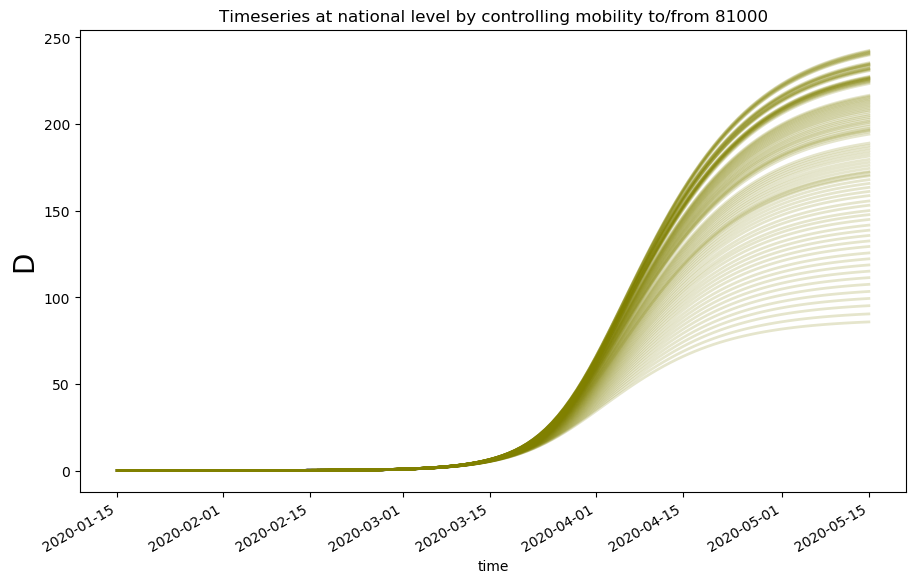

In [157]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, \
                                NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

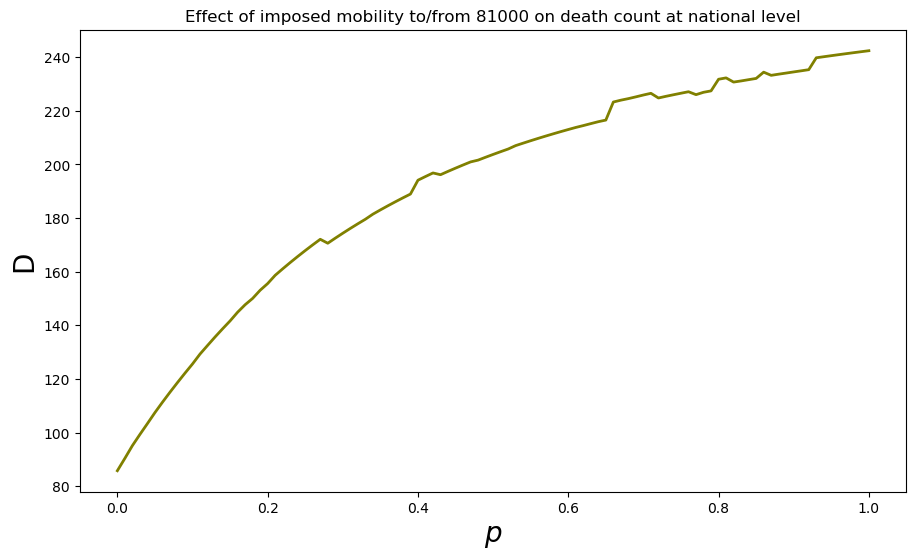

In [158]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, \
                                NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

## With actual mobility as baseline

# Model: Keeping it out
Drop 3 40-year olds in the initial Belgian hotspots, partially isolate Brussels/Arlon, and look at effect.

## With average prepandemic mobility as baseline

In [161]:
params.update({'place' : average_prepandemic_mobility})
savename_prefix=f"effect-of-isolation_{agg}_keeping-it-out_fixed-baseline-mobility"

# Save figures
save=True

### Partial isolation of Brussels

In [162]:
# Set this to True if you want to run. Takes approximately 5 minutes
rerun=False
color='maroon'

# Identify arrondissement Brussels and find corresponding index in the NIS list
NIS = 21000
NIS_list = read_coordinates_nis(spatial=agg)
p_index = np.where(NIS_list==NIS)[0][0]

# Initialise mobility parameter array (no mobility policy)
p = np.ones(len(NIS_list))

# Define simulation result dictionary
results_dict = dict.fromkeys(p_values)

# Initial states
initE = initial_state(dist='data', agg=agg, age=40, number=3) # 3 40-somethings dropped in initial hotspots
initial_states = {'S': initN, 'E': initE}

if rerun==True:
    for p_value in p_values:
        # Update mobility parameter array with new p-value
        p[p_index] = p_value
        params.update({'p' : p})
        # Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
        # Note: no time-dependent mobility
        model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters \
                                                   = {'Nc' : policies_wave1_4prev}, spatial=agg)
        out = model_wave1.sim(end_date, start_date=start_date)
        results_dict[p_value] = out
        print(f"Finished working on p={p_value}   ", end='\r')

**Results**

*Results for Brussels*

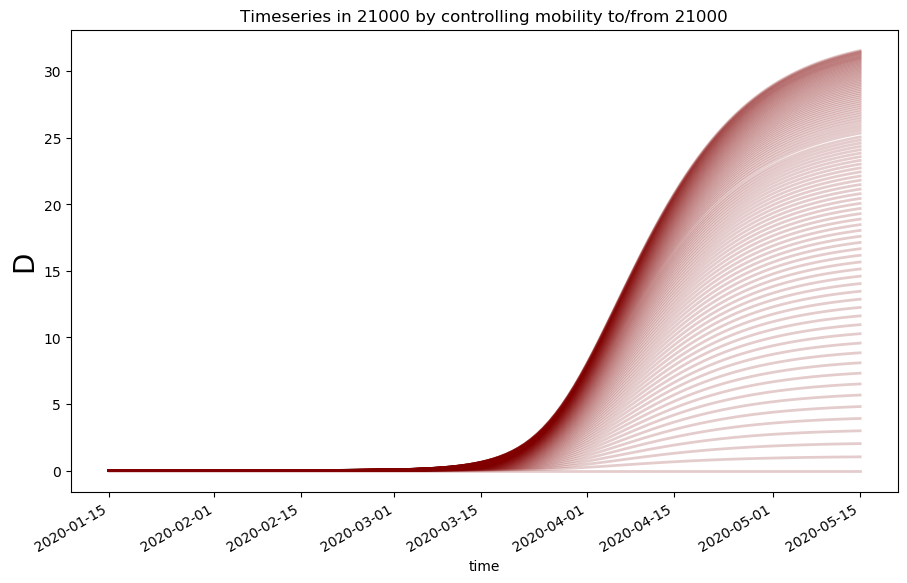

In [163]:
NIS_isolated=21000
NIS=21000
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

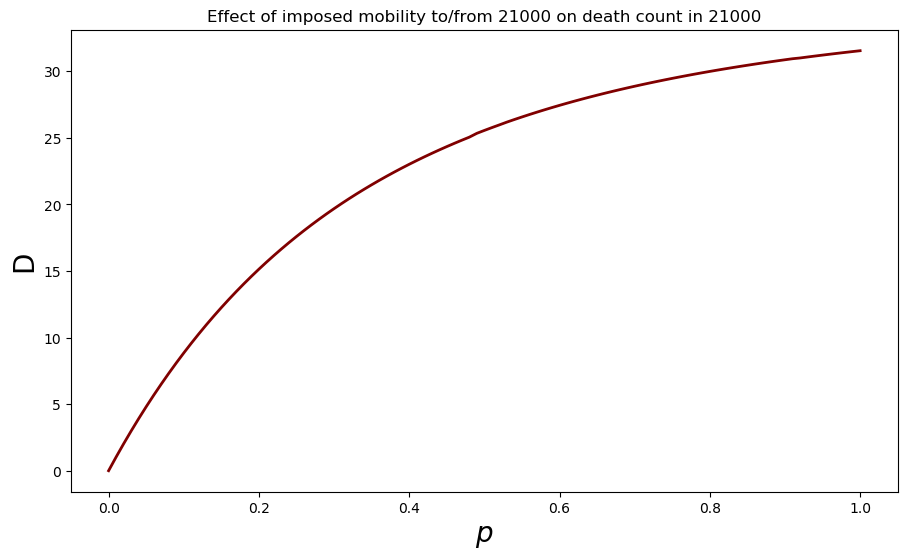

In [164]:
NIS=21000
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

Results for all of Belgium

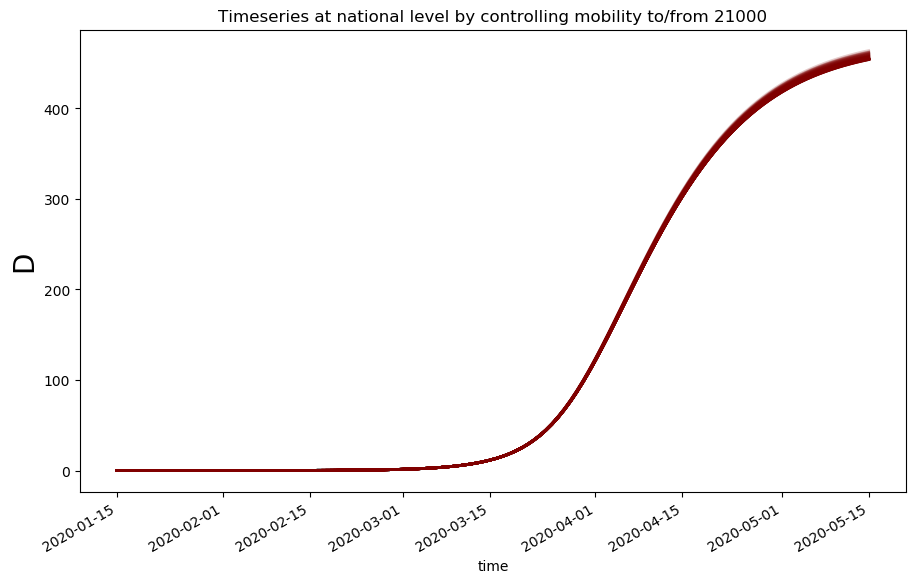

In [165]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

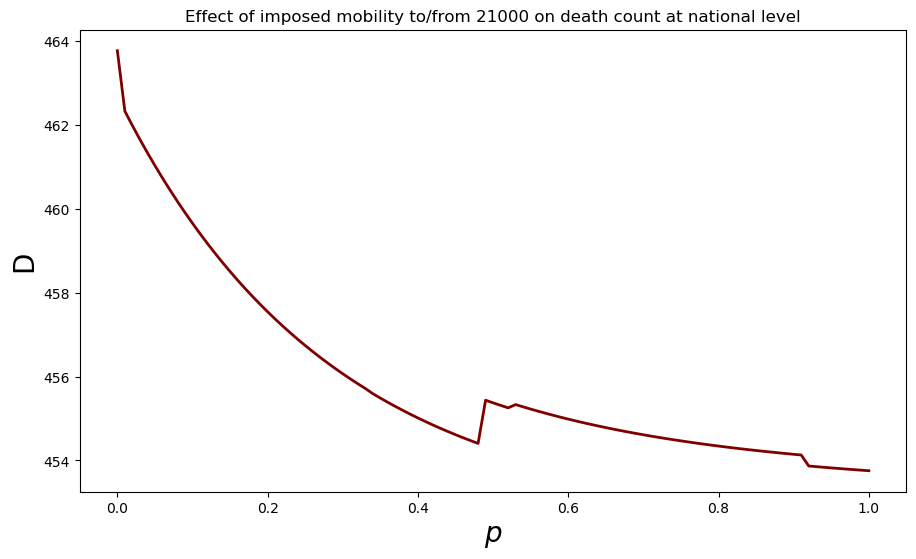

In [166]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

### Partial isolation of Arlon

In [168]:
# Set this to True if you want to run. Takes approximately 5 minutes
rerun=False
color='olive'

# Identify arrondissement Arlon and find corresponding index in the NIS list
NIS = 81000
NIS_list = read_coordinates_nis(spatial=agg)
p_index = np.where(NIS_list==NIS)[0][0]

# Initialise mobility parameter array (no mobility policy)
p = np.ones(len(NIS_list))

# Define simulation result dictionary
results_dict = dict.fromkeys(p_values)

# Initial states
initE = initial_state(dist='data', agg=agg, age=40, number=3) # 3 40-somethings dropped in initial hotspots
initial_states = {'S': initN, 'E': initE}

if rerun==True:
    for p_value in p_values:
        # Update mobility parameter array with new p-value
        p[p_index] = p_value
        params.update({'p' : p})
        # Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
        # Note: no time-dependent mobility
        model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters \
                                                   = {'Nc' : policies_wave1_4prev}, spatial=agg)
        out = model_wave1.sim(end_date, start_date=start_date)
        results_dict[p_value] = out
        print(f"Finished working on p={p_value}   ", end='\r')

**Results**

*Results for Arlon*

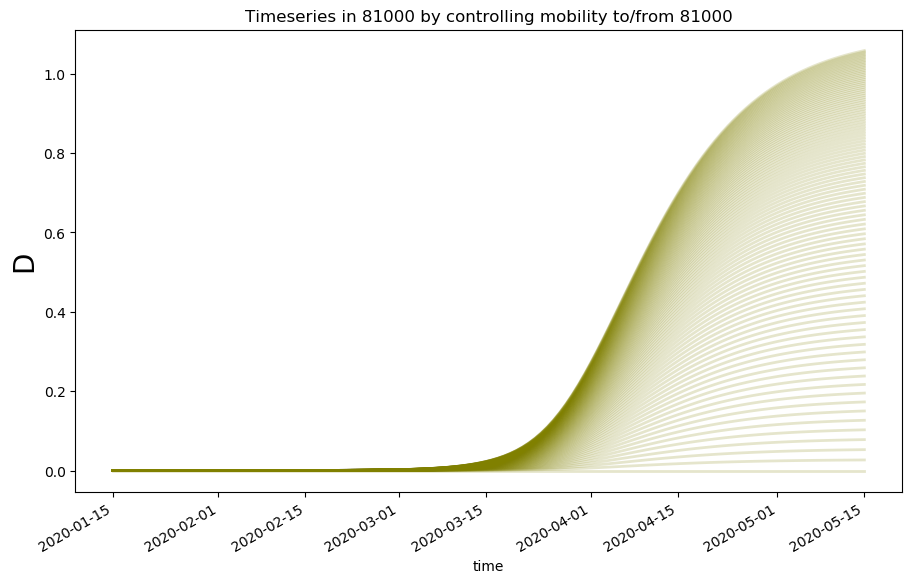

In [173]:
NIS_isolated=81000
NIS=81000
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

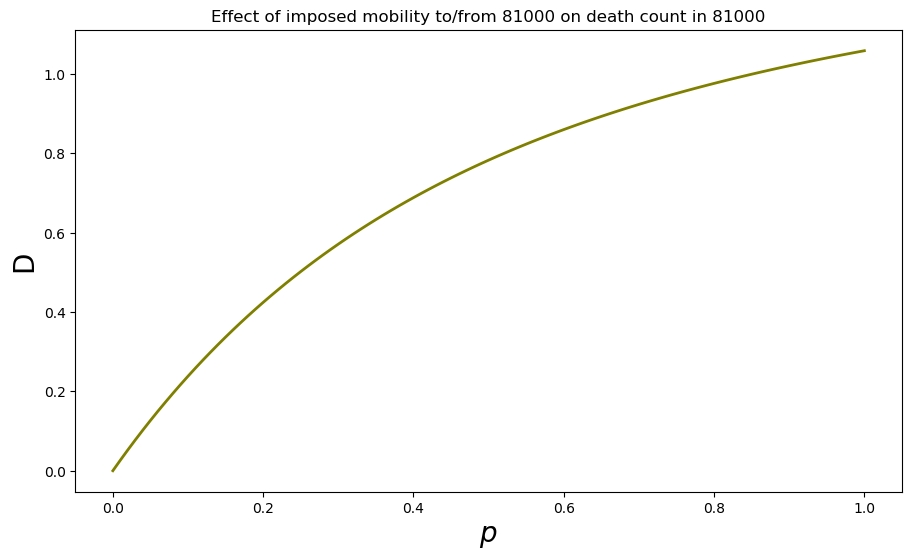

In [174]:
NIS=81000
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{NIS}.png", dpi=dpi, bbox_inches='tight')

*Results for all of Belgium*

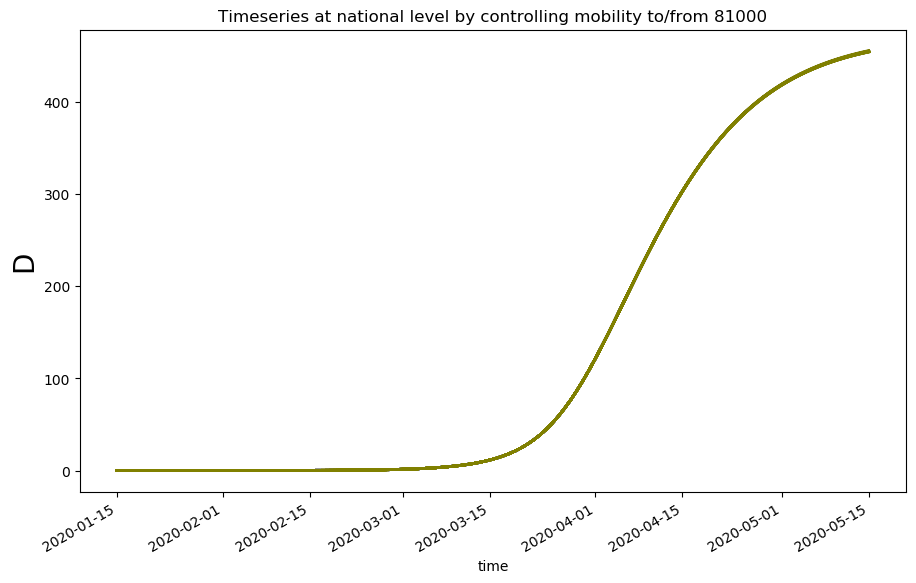

In [175]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='timeseries'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

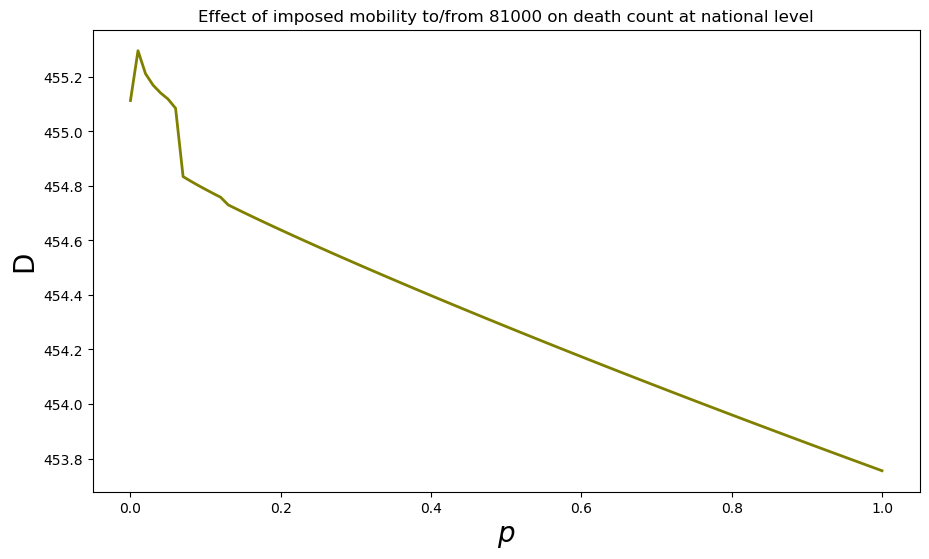

In [176]:
NIS=None
if not NIS:
    result_for_NIS = 'all'
dtype='result'
compartment='D'

fig, ax = show_isolation_effect(results_dict, NIS_isolated, p_values, dtype=dtype, compartment=compartment, NIS=NIS, figsize=figsize, color=color)
ax.grid(False)
if save:
    plt.savefig(f"{savename_prefix}_{dtype}_{compartment}_isolate-{NIS_isolated}_result-for-{result_for_NIS}.png", dpi=dpi, bbox_inches='tight')

In [3]:
# Define daily mobility time-dependent function
mobility_update_func = make_mobility_update_func(all_mobility_data, average_mobility_data)

# Add the necessary arguments for the mobility_update_func
params.update({'default_mobility' : None}) # mobility defaults to average mobility

In [6]:
# Identify arrondissement Brussels and find corresponding index in the NIS list
NIS = 21000
NIS_list = read_coordinates_nis(spatial=agg)
p_index = np.where(NIS_list==NIS)[0][0]

# Initialise mobility parameter array (no mobility policy)
p = np.ones(len(NIS_list))

# Define simulation result dictionary
# results_dict = dict.fromkeys(p_values)

# Initial states
initE = initial_state(dist='data', agg=agg, age=40, number=3) # 1000 40-somethings dropped in Arlon
initial_states = {'S': initN, 'E': initE}

model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters \
                                        = {'Nc' : policies_wave1_4prev, 'place' : mobility_update_func}, spatial=agg)

start_date = pd.to_datetime('2020-01-15')
end_date = pd.to_datetime('2020-05-15')

model_wave1.sim(end_date, start_date=start_date, warmup=10)

# for p_value in p_values:
#     # Update mobility parameter array with new p-value
#     p[p_index] = p_value
#     params.update({'p' : p})
#     # Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
#     model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters \
#                                             = {'Nc' : policies_wave1_4prev, 'place' : mobility_update_func}, spatial=agg)
#     out = model_wave1.sim(end_date, start_date=start_date)
#     results_dict[p_value] = out
#     print(f"Finished working on p={p_value}   ", end='\r')

TypeError: unhashable type: 'dict'

In [ ]:
# Plot results for national effect
fig, ax = plt.subplots(figsize=(15,5))

for p_value in p_values:
    total_death_timeseries = results_dict[p_value].sum(dim='place').sum(dim='Nc')['D']
    local_death_timeseries = results_dict[p_value].sel(place=NIS).sum(dim='Nc')['D']
    (total_death_timeseries - local_death_timeseries).plot(color='orange', linewidth=2, alpha=0.2, ax=ax)
    
ax.set_title(f'Total national death count with varying regulated mobility in {NIS}', size=18)
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel('Number of deceased subjects', size=14)
text = plt.figtext(0.2, 0.3,'Actual mobility', backgroundcolor='whitesmoke', fontsize=16)

In [49]:
first_date = mobility.date_to_YYYYMMDD('20200420', inverse=True)
second_date = mobility.date_to_YYYYMMDD('20200421', inverse=True)

dates = [first_date, second_date]
df = pd.DataFrame({'DATE' : dates, 'place' : None})
df['DATE'] = pd.to_datetime(df['DATE'])

df

# pd.to_datetime(dates, format="%Y%m%d").strftime('%Y%m%d')

,DATE,place
0,2020-04-20,None
1,2020-04-21,None


In [74]:
import os

directory = f'../../data/interim/mobility/arr/fractional'

all_available_dates=[]
all_available_places=[]
for csv in os.listdir(directory):
    # take YYYYMMDD information from processed CSVs. NOTE: this supposes a particular data name format!
    datum = csv[-12:-4]
    # Create list of datetime objects
    all_available_dates.append(pd.to_datetime(datum, format="%Y%m%d"))
    # Load the CSV as a np.array
    place = pd.read_csv(f'{directory}/{csv}', index_col='mllp_postalcode').drop(index='Foreigner', columns='ABROAD').values
    place = place / place.sum(axis=1)
    # Create list of places
    all_available_places.append(place)
# Create new empty dataframe with available dates. Load mobility later
df = pd.DataFrame({'DATE' : all_available_dates, 'place' : all_available_places}).set_index('DATE')

In [76]:
df['place'].values.mean()

array([[9.21048664e-01, 1.31583640e-02, 9.69883149e-03, ...,
        1.10915405e-03, 8.60615885e-04, 2.58285367e-04],
       [3.63316380e-02, 8.64759419e-01, 1.26616336e-02, ...,
        1.13334410e-03, 1.02359544e-03, 2.56065812e-04],
       [2.27900766e-02, 9.85038841e-03, 9.08801034e-01, ...,
        7.60979377e-04, 6.32842539e-04, 1.78956711e-04],
       ...,
       [1.35795819e-03, 4.81933267e-04, 3.90436179e-04, ...,
        8.55735306e-01, 3.93540780e-02, 4.58558541e-03],
       [1.18483540e-03, 4.44778697e-04, 3.91873770e-04, ...,
        1.28158764e-02, 8.85294287e-01, 2.89465537e-03],
       [1.10719259e-03, 4.20703075e-04, 2.98994710e-04, ...,
        1.25897102e-02, 1.81953488e-02, 8.43750582e-01]])

In [86]:
all_mobility_data, average_mobility_data = load_all_mobility_data(agg)

In [94]:
mobility_update_func = make_mobility_update_func(all_mobility_data, average_mobility_data)
mobility_update_func(pd.to_datetime('20190420', format="%Y%m%d"), 0, 0)

array([[9.21048664e-01, 1.31583640e-02, 9.69883149e-03, ...,
        1.10915405e-03, 8.60615885e-04, 2.58285367e-04],
       [3.63316380e-02, 8.64759419e-01, 1.26616336e-02, ...,
        1.13334410e-03, 1.02359544e-03, 2.56065812e-04],
       [2.27900766e-02, 9.85038841e-03, 9.08801034e-01, ...,
        7.60979377e-04, 6.32842539e-04, 1.78956711e-04],
       ...,
       [1.35795819e-03, 4.81933267e-04, 3.90436179e-04, ...,
        8.55735306e-01, 3.93540780e-02, 4.58558541e-03],
       [1.18483540e-03, 4.44778697e-04, 3.91873770e-04, ...,
        1.28158764e-02, 8.85294287e-01, 2.89465537e-03],
       [1.10719259e-03, 4.20703075e-04, 2.98994710e-04, ...,
        1.25897102e-02, 1.81953488e-02, 8.43750582e-01]])

In [5]:
pd.to_datetime('20200420')

Timestamp('2020-04-20 00:00:00')